In [0]:
# Downloads the Physionet 2017 ECG dataset
#! wget -r -N -c -np -nv -q https://physionet.org/files/challenge-2017/1.0.0/

In [2]:
# Run this for pre-processesed dataset file
! git clone https://github.com/kendreaditya/ECG_DATA.git

Cloning into 'ECG_DATA'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [0]:
# Pre-processing data
#   Randomize data
#   Data augmentation
#     Zero Bursts*
#     Random Resampling*
#   Keep metadata*
#   
# Convoluntional Model
#   Time dependent features
#   Frequency dependent features
#   Technique cardiologists use in ECG interpertation

In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import torch

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on GPU -", device )
else:
  device = torch.device("cpu")
  print("Running on CPU -", device )

# to run on gpu .to(device)

REBUILD_DATA = False # processing data

Running on GPU - cuda:0


In [0]:
class ECG_DATA():
  ECG_LENGTH = 3000
  LABEL_SIZE = 485
  DATA = "physionet.org/files/challenge-2017/1.0.0/training/"
  NORMAL = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-normal" 
  AF = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af"
  OTHER = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-other"
  NOISY = "physionet.org/files/challenge-2017/1.0.0/training/RECORDS-noisy"
  LABELS = {NORMAL: 0, AF: 1, OTHER:2, NOISY: 3}
  trainingData = []
  dataCount = {NORMAL: 0, AF: 0, OTHER: 0, NOISY: 0}

  def make_training_data(self):
    for records in self.LABELS:
      with open(records) as label:
        for ecgFile in tqdm(label):
          ecg = loadmat(self.DATA+ecgFile[:-1]+".mat")["val"][0].tolist()

          
          if records == self.NOISY:
            #self.zero_padding(ecg)
            for x in range(self.ECG_LENGTH, len(ecg), self.ECG_LENGTH):
              if self.dataCount[records] <= self.LABEL_SIZE and x <= len(ecg):
                self.trainingData.append([np.array(ecg[x-self.ECG_LENGTH:x]), np.eye(len(self.LABELS))[self.LABELS[records]]])
                self.dataCount[records] += 1

          elif self.dataCount[records] <= self.LABEL_SIZE and self.ECG_LENGTH <= len(ecg):
            self.trainingData.append([np.array(ecg[:self.ECG_LENGTH]), np.eye(len(self.LABELS))[self.LABELS[records]]])
            self.dataCount[records] += 1
          
          # try with this is overfitting first
          '''
          if len(ecg)%self.ECG_LENGTH != 0:
            self.zero_padding(ecg)

          for x in range(self.ECG_LENGTH, len(ecg), self.ECG_LENGTH):
            if self.dataCount[records] <= self.LABEL_SIZE:
              self.trainingData.append([np.array(ecg[x-self.ECG_LENGTH:x]), np.eye(len(self.LABELS))[self.LABELS[records]]])
              self.dataCount[records] += 1
            else:
              break
          '''
            
    
    print(self.dataCount)
    np.random.shuffle(self.trainingData)
    np.save("training_Data.npy", self.trainingData)
  
  def zero_padding(self, ecg):
    ecg += [0] * (self.ECG_LENGTH-(len(ecg)%self.ECG_LENGTH))

if REBUILD_DATA:
  ECG = ECG_DATA()
  ECG.make_training_data()

In [6]:
try:
  training_data = np.load("training_Data.npy", allow_pickle=True)
  np.random.shuffle(training_data)
except Exception as e:
  training_data = np.load("ECG_DATA/training_Data.npy", allow_pickle=True)
  np.random.shuffle(training_data)
print(len(training_data))

1944


In [193]:
import torch.nn as nn
import torch.nn.functional as f

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dropout_rate = 0.5256155474817464
        class_num = 4

        self.conv1 = nn.Conv1d(1, 64, 7)
        self.conv1_bn = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 7)
        self.conv2_bn = nn.BatchNorm1d(64)
        self.maxpool1 = nn.MaxPool1d(3, 3)
        self.conv3 = nn.Conv1d(64, 128, 7)
        self.conv3_bn = nn.BatchNorm1d(128)
        self.conv4 = nn.Conv1d(128, 128, 7)
        self.conv4_bn = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(3, 3)
        self.conv5 = nn.Conv1d(128, 192, 7)
        self.conv5_bn = nn.BatchNorm1d(192)
        self.conv6 = nn.Conv1d(192, 192, 7)
        self.conv6_bn = nn.BatchNorm1d(192)
        self.maxpool3 = nn.MaxPool1d(3, 3)
        self.conv7 = nn.Conv1d(192, 256, 7)
        self.conv7_bn = nn.BatchNorm1d(256)
        self.conv8 = nn.Conv1d(256, 256, 7)
        self.conv8_bn = nn.BatchNorm1d(256)
        self.maxpool4 = nn.MaxPool1d(3, 3)
        self.conv9 = nn.Conv1d(256, 320, 5)
        self.conv9_bn = nn.BatchNorm1d(320)
        self.conv10 = nn.Conv1d(320, 320, 5)
        self.conv10_bn = nn.BatchNorm1d(320)
        self.avgpool1 = nn.AvgPool1d(4, 4)
        self.fc1 = nn.Linear(1600, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        self.fc1_drop = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, class_num)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = f.relu(x)

        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = f.relu(x)

        x = self.maxpool1(x)

        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = f.relu(x)

        x = self.conv4(x)
        x = self.conv4_bn(x)
        x = f.relu(x)

        x = f.pad(x, (0,1))
        x = self.maxpool2(x)

        x = self.conv5(x)
        x = self.conv5_bn(x)
        x = f.relu(x)

        x = self.conv6(x)
        x = self.conv6_bn(x)
        x = f.relu(x)

        x = f.pad(x, (0,1))
        x = self.maxpool3(x)

        x = self.conv7(x)
        x = self.conv7_bn(x)
        x = f.relu(x)

        x = self.conv8(x)
        x = self.conv8_bn(x)
        x = f.relu(x)

        x = self.maxpool4(x)

        x = self.conv9(x)
        x = self.conv9_bn(x)
        x = f.relu(x)

        x = self.conv10(x)
        x = self.conv10_bn(x)
        x = f.relu(x)

        x = self.avgpool1(x)
        
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = f.relu(x)
        x = self.fc1_drop(x)

        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num = 1
        for s in size:
            num *= s
        return num


net = Net().to(device)
print(net)


Net(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(1,))
  (conv1_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (conv2_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(7,), stride=(1,))
  (conv3_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(128, 128, kernel_size=(7,), stride=(1,))
  (conv4_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(128, 192, kernel_size=(7,), stride=(1,))
  (conv5_bn): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(192, 192, kernel_size=(7,), stride=(1

In [186]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss().to(device)

X = torch.Tensor([i[0] for i in training_data])
y = torch.Tensor([i[1] for i in training_data])
 
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

194


In [83]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

1750 194


 11%|█         | 2/18 [00:00<00:01, 11.43it/s]


Epoch: 0. Loss: 0.4876205325126648. Accuracy: 25.829


 11%|█         | 2/18 [00:00<00:01, 11.44it/s]


Epoch: 1. Loss: 0.6111233234405518. Accuracy: 24.829


100%|██████████| 18/18 [00:01<00:00, 12.28it/s]


Epoch: 2. Loss: 0.5598663687705994. Accuracy: 25.333


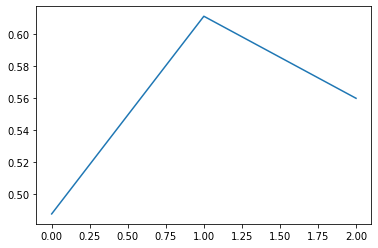

In [205]:
import matplotlib.pyplot as plt

BATCH_SIZE = 100
EPOCHS = 3
plot = []
total, correct = 0, 0

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,3000).to(device) # input: (batch_size, channels (1), ECG_LENGTH)
        #print(batch_X.shape)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)

        net.zero_grad()

        outputs = net(batch_X)
        #print(torch.argmax(outputs[0]), torch.argmax(batch_y[0]))
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

        for i in range(len(outputs)):
          if torch.argmax(outputs[i]) == torch.argmax(batch_y[i]):
            correct += 1
          total +=1
    
    plot.append([epoch, float(loss)])
    print(f"\nEpoch: {epoch}. Loss: {loss}. Accuracy: {round(correct/total*100, 3)}")

plot = list(map(list, zip(*plot)))
plt.plot(plot[0], plot[1])

In [199]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i]).to(device)
        net_out = net(test_X[i].view(-1,1,3000).to(device))[0]  # returns a list
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total*100, 3))

  0%|          | 0/194 [00:00<?, ?it/s]


ValueError: ignored

In [196]:
num = 70

print(torch.argmax(test_y[num]))
print(torch.argmax(net(test_X[num].view(-1,1,3000).to(device))))

tensor(1)


ValueError: ignored

In [197]:
num = 6
print(test_y[num])
print(net(torch.Tensor(test_X[num].view(-1,1,3000)).to(device)))

tensor([0., 0., 1., 0.])


ValueError: ignored

In [0]:
! pip install config

In [0]:
print(batch_X.shape)
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)
print(output.shape)

In [50]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # just run the init of parent class (nn.Module)
        
        self.conv1 = nn.Conv1d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv1d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv1d(64, 128, 5)

        x = torch.randn(100,1,3000).view(-1,1,3000)
        print(x.shape)
        self._to_linear = None
        self.convs(x)
        print(self._to_linear)
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 4) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

    def convs(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 2) # adjust shape of pooling?
        x = F.max_pool1d(F.relu(self.conv2(x)), 2) # x = F.max_pool1d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net().to(device)
print(net)


torch.Size([100, 1, 3000])
47488
Net(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=47488, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)
